In [85]:
# Mendeteksi anomali aktivitas seismik menggunakan pendekatan unsupervised seperti Isolation Forest dan One-Class SVM.

<h5>A. DATASET UMUM</h5>

Persiapan Data

In [86]:
import pandas as pd

# Load data
df = pd.read_csv("seismic_gap_clean.csv")
df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')
df = df.dropna(subset=['date'])  # Buang baris yang gagal parsing


# Agregasi jumlah gempa per tahun
yearly_quakes = df['date'].dt.year.value_counts().sort_index()
yearly_quakes = yearly_quakes.reset_index()
yearly_quakes.columns = ['year', 'count']


A. Deteksi Anomali dengan Isolation Forest

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [88]:
# === 1. Load & Preprocess ===
df = pd.read_csv("seismic_gap_clean.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='mixed')
df = df.dropna(subset=['date', 'mag'])
df['year'] = df['date'].dt.year
df = df[df['year'] >= 1982]

# === 2. Agregasi fitur per tahun ===
agg = df.groupby('year')['mag'].agg(
    count='count',
    total_mag='sum',
    mean_mag='mean',
    std_mag='std'
).reset_index()

In [89]:
# === 3. Isolation Forest (Multivariat) ===
features = ['count', 'total_mag', 'mean_mag']
iso = IsolationForest(contamination=0.1, random_state=42)
agg['anomaly'] = iso.fit_predict(agg[features])
agg['label'] = agg['anomaly'].map({1: 'Normal', -1: 'Anomali'})

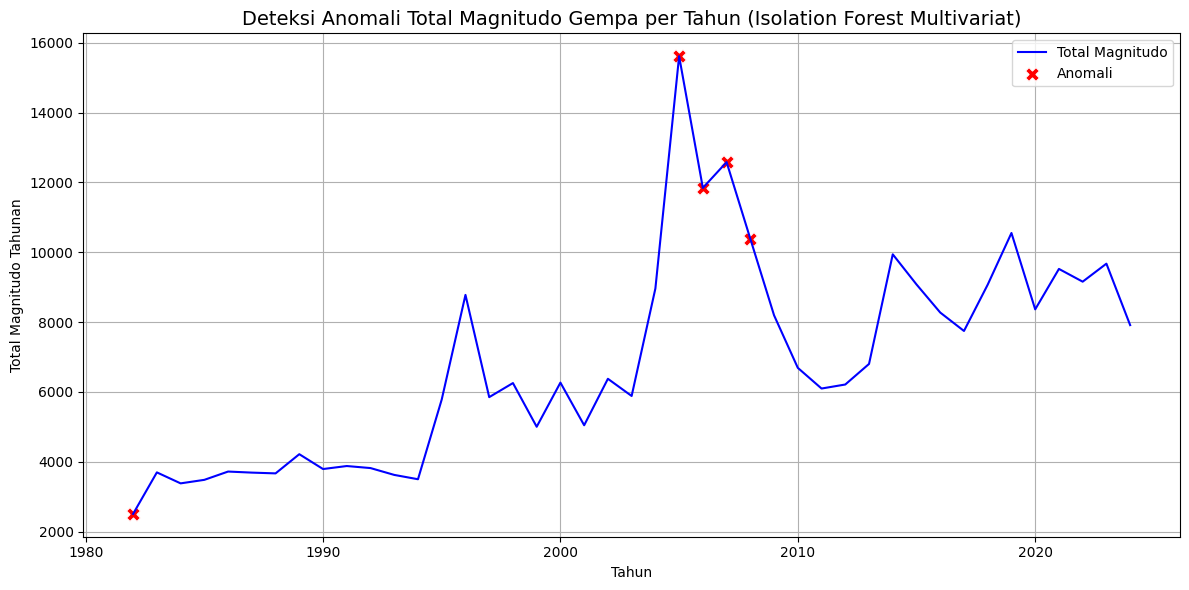

In [90]:
# === 4. Visualisasi Total Magnitudo + Anomali ===
plt.figure(figsize=(12, 6))
sns.lineplot(data=agg, x='year', y='total_mag', label='Total Magnitudo', color='blue')
sns.scatterplot(
    data=agg[agg['label'] == 'Anomali'],
    x='year', y='total_mag', color='red', label='Anomali', marker='X', s=100
)
plt.title("Deteksi Anomali Total Magnitudo Gempa per Tahun (Isolation Forest Multivariat)", fontsize=14)
plt.xlabel("Tahun")
plt.ylabel("Total Magnitudo Tahunan")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [91]:
# === 6. Jumlah tahun anomali ===
jumlah_anomali = agg[agg['label'] == 'Anomali'].shape[0]
print(f"🔴 Jumlah tahun yang terdeteksi sebagai anomali: {jumlah_anomali} tahun")
print("📅 Tahun-tahun anomali:")
print(agg[agg['label'] == 'Anomali']['year'].tolist())

# === 7. Profil tahun anomali ===
anomali_stats = agg.groupby('label')[['count', 'total_mag', 'mean_mag']].describe()
print(anomali_stats)


🔴 Jumlah tahun yang terdeteksi sebagai anomali: 5 tahun
📅 Tahun-tahun anomali:
[1982, 2005, 2006, 2007, 2008]
        count                                                            \
        count         mean          std    min      25%     50%     75%   
label                                                                     
Anomali   5.0  2361.200000  1100.464084  525.0  2367.00  2659.0  2804.0   
Normal   38.0  1398.447368   530.876109  702.0   793.25  1355.0  1876.5   

                total_mag             ...                     mean_mag  \
            max     count       mean  ...        75%      max    count   
label                                 ...                                
Anomali  3451.0       5.0  10584.980  ...  12580.500  15613.7      5.0   
Normal   2336.0      38.0   6365.305  ...   8340.225  10550.3     38.0   

                                                                               
             mean       std       min       25%       50%      

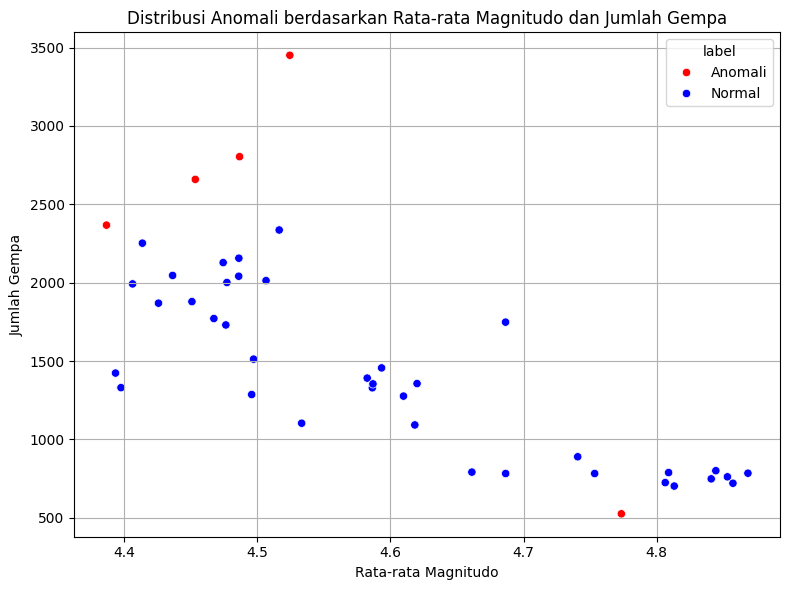

In [92]:
# === 8. Visualisasi dimensi ganda ===
plt.figure(figsize=(8,6))
sns.scatterplot(data=agg, x='mean_mag', y='count', hue='label', palette={'Normal': 'blue', 'Anomali': 'red'})
plt.title("Distribusi Anomali berdasarkan Rata-rata Magnitudo dan Jumlah Gempa")
plt.xlabel("Rata-rata Magnitudo")
plt.ylabel("Jumlah Gempa")
plt.grid(True)
plt.tight_layout()
plt.show()


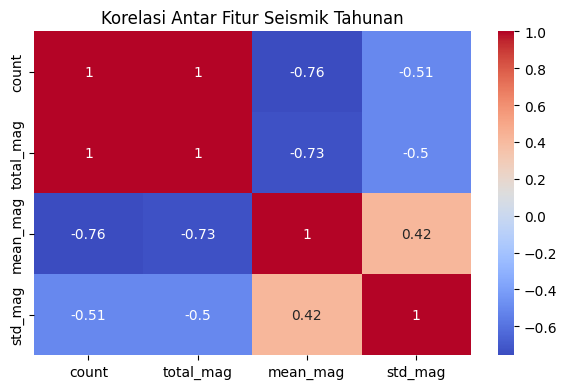

In [93]:
# === 9. Heatmap korelasi fitur ===
plt.figure(figsize=(6,4))
sns.heatmap(agg[['count', 'total_mag', 'mean_mag', 'std_mag']].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi Antar Fitur Seismik Tahunan")
plt.tight_layout()
plt.show()


In [94]:
# === 10. Anomali skor ===
agg['anomaly_score'] = iso.score_samples(agg[features])
print(agg[['year', 'anomaly_score']].sort_values(by='anomaly_score'))

# ✅ Tambahkan label_iforest agar tidak hilang
agg['label_iforest'] = agg['label']

# ✅ Simpan versi IF
agg_iforest = agg.copy()


    year  anomaly_score
23  2005      -0.726746
0   1982      -0.654856
25  2007      -0.588798
24  2006      -0.553513
26  2008      -0.547835
27  2009      -0.543470
7   1989      -0.539474
2   1984      -0.511523
17  1999      -0.507339
32  2014      -0.500277
15  1997      -0.499170
16  1998      -0.494931
12  1994      -0.494291
5   1987      -0.492354
37  2019      -0.492213
9   1991      -0.490693
19  2001      -0.487741
10  1992      -0.483349
6   1988      -0.481801
3   1985      -0.475715
4   1986      -0.463434
34  2016      -0.463191
11  1993      -0.460818
14  1996      -0.459785
1   1983      -0.458440
8   1990      -0.452881
28  2010      -0.448073
31  2013      -0.447812
42  2024      -0.447452
13  1995      -0.446393
38  2020      -0.445930
33  2015      -0.443853
21  2003      -0.442509
35  2017      -0.437734
18  2000      -0.436757
20  2002      -0.427105
41  2023      -0.422811
39  2021      -0.421951
29  2011      -0.421108
30  2012      -0.417990
36  2018      -0

B. Deteksi Anomali dengan One-Class SVM

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [96]:
# === 1. Load dan Siapkan Data ===
df = pd.read_csv("seismic_gap_clean.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='mixed')
df = df.dropna(subset=['date', 'mag'])
df['year'] = df['date'].dt.year
df = df[df['year'] >= 1982]

In [97]:
# === 2. Agregasi Fitur Tambahan per Tahun ===
agg = df.groupby('year')['mag'].agg(
    count='count',
    total_mag='sum',
    mean_mag='mean',
    std_mag='std'
).reset_index()

In [98]:
# === 3. Scaling dan One-Class SVM ===
features = ['count', 'total_mag', 'mean_mag']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg[features])

ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
agg['anomaly_ocsvm'] = ocsvm.fit_predict(X_scaled)
agg['label_ocsvm'] = agg['anomaly_ocsvm'].map({1: 'Normal', -1: 'Anomali'})

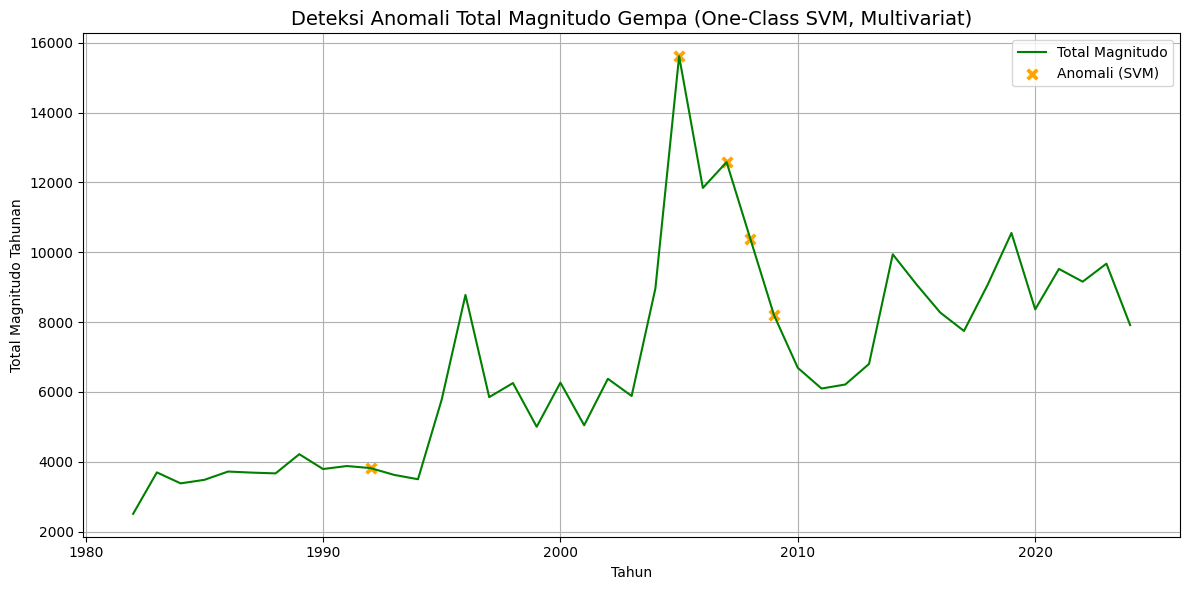

In [99]:
# === 4. Visualisasi Total Magnitudo + Anomali ===
plt.figure(figsize=(12, 6))
sns.lineplot(data=agg, x='year', y='total_mag', label='Total Magnitudo', color='green')
sns.scatterplot(
    data=agg[agg['label_ocsvm'] == 'Anomali'],
    x='year', y='total_mag', color='orange', label='Anomali (SVM)', marker='X', s=100
)
plt.title("Deteksi Anomali Total Magnitudo Gempa (One-Class SVM, Multivariat)", fontsize=14)
plt.xlabel("Tahun")
plt.ylabel("Total Magnitudo Tahunan")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
# === 5. Statistik Ringkasan & Tahun Anomali ===
jumlah_anomali_ocsvm = agg[agg['label_ocsvm'] == 'Anomali'].shape[0]
print(f"🟠 Jumlah tahun anomali (SVM): {jumlah_anomali_ocsvm} tahun")
print("📅 Tahun-tahun anomali:")
print(agg[agg['label_ocsvm'] == 'Anomali']['year'].tolist())


🟠 Jumlah tahun anomali (SVM): 5 tahun
📅 Tahun-tahun anomali:
[1992, 2005, 2007, 2008, 2009]


In [101]:
# === 6. Statistik Bandingkan Anomali vs Normal ===
print("\n📊 Ringkasan Statistik (SVM):")
print(agg.groupby('label_ocsvm')[['count', 'total_mag', 'mean_mag']].describe())



📊 Ringkasan Statistik (SVM):
            count                                                             \
            count         mean          std    min      25%     50%      75%   
label_ocsvm                                                                    
Anomali       5.0  2230.800000  1020.088575  784.0  1748.00  2367.0  2804.00   
Normal       38.0  1415.605263   575.834836  525.0   793.25  1355.0  1963.75   

                    total_mag                ...                       \
                max     count          mean  ...         75%      max   
label_ocsvm                                  ...                        
Anomali      3451.0       5.0  10117.260000  ...  12580.5000  15613.7   
Normal       2659.0      38.0   6426.847105  ...   8673.6675  11841.5   

            mean_mag                                                    \
               count      mean       std       min       25%       50%   
label_ocsvm                                            

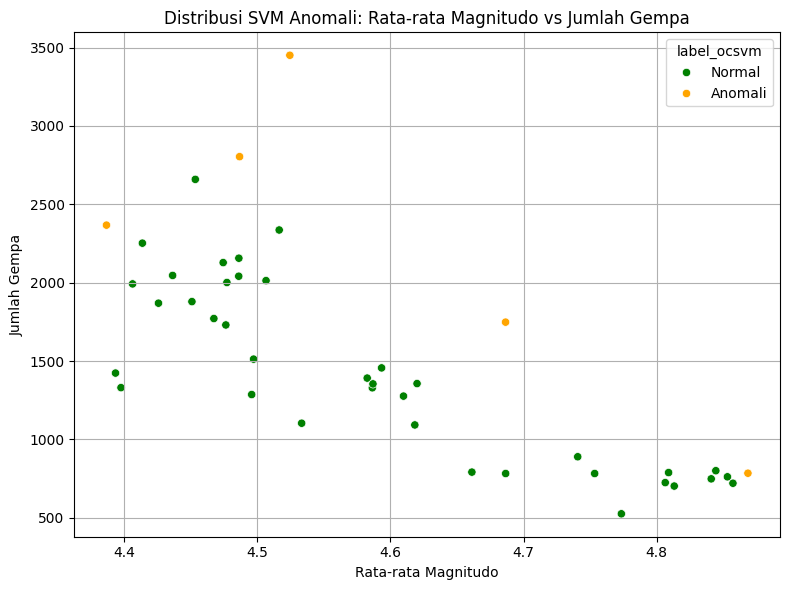

In [102]:
# === 7. Visualisasi dimensi ganda ===
plt.figure(figsize=(8,6))
sns.scatterplot(data=agg, x='mean_mag', y='count', hue='label_ocsvm', palette={'Normal': 'green', 'Anomali': 'orange'})
plt.title("Distribusi SVM Anomali: Rata-rata Magnitudo vs Jumlah Gempa")
plt.xlabel("Rata-rata Magnitudo")
plt.ylabel("Jumlah Gempa")
plt.grid(True)
plt.tight_layout()
plt.show()


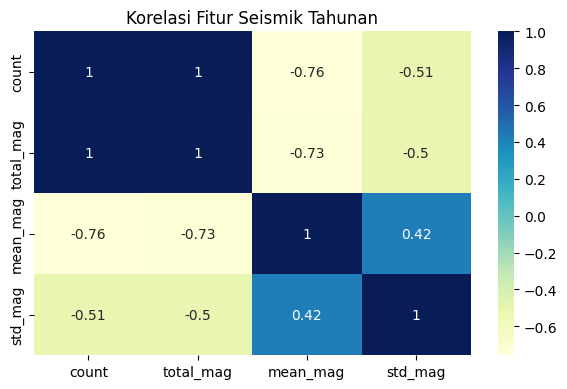

In [103]:
# === 8. Heatmap korelasi fitur ===
plt.figure(figsize=(6,4))
sns.heatmap(agg[['count', 'total_mag', 'mean_mag', 'std_mag']].corr(), annot=True, cmap='YlGnBu')
plt.title("Korelasi Fitur Seismik Tahunan")
plt.tight_layout()
plt.show()

# SIMPAN HASIL SVM
agg_ocsvm = agg.copy()

In [104]:
### Perbandingan ###

# Gabungkan berdasarkan tahun
agg_merged = pd.merge(agg_iforest, agg_ocsvm[['year', 'label_ocsvm']], on='year', how='inner')

tahun_iforest = set(agg_merged[agg_merged['label_iforest'] == 'Anomali']['year'])
tahun_ocsvm = set(agg_merged[agg_merged['label_ocsvm'] == 'Anomali']['year'])

print(f"📌 Tahun anomali oleh kedua model: {sorted(tahun_iforest & tahun_ocsvm)}")
print(f"🧠 Hanya oleh Isolation Forest: {sorted(tahun_iforest - tahun_ocsvm)}")
print(f"🧠 Hanya oleh SVM: {sorted(tahun_ocsvm - tahun_iforest)}")


📌 Tahun anomali oleh kedua model: [2005, 2007, 2008]
🧠 Hanya oleh Isolation Forest: [1982, 2006]
🧠 Hanya oleh SVM: [1992, 2009]


<h5>B. DATASET KLASIFIKASI</H5>

Persiapan Data

In [109]:
import pandas as pd

# Load data
df = pd.read_csv("hasil_clustering_gempa.csv")
df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')
df = df.dropna(subset=['date'])  # Buang baris yang gagal parsing


# Agregasi jumlah gempa per tahun
yearly_quakes = df['date'].dt.year.value_counts().sort_index()
yearly_quakes = yearly_quakes.reset_index()
yearly_quakes.columns = ['year', 'count']

A. Deteksi Anomali dengan Isolation Forest

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [111]:
# === 1. Load & Preprocessing ===
df = pd.read_csv("hasil_clustering_gempa.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date', 'cluster'])
df['year'] = df['date'].dt.year
df = df[df['year'] >= 1982]

# === 2. Agregasi jumlah gempa per tahun per cluster ===
cluster_counts = df.groupby(['year', 'cluster']).size().unstack(fill_value=0)


📌 Isolation Forest - Cluster 0
🟥 Tahun anomali: [1997, 2005, 2006, 2007, 2009]


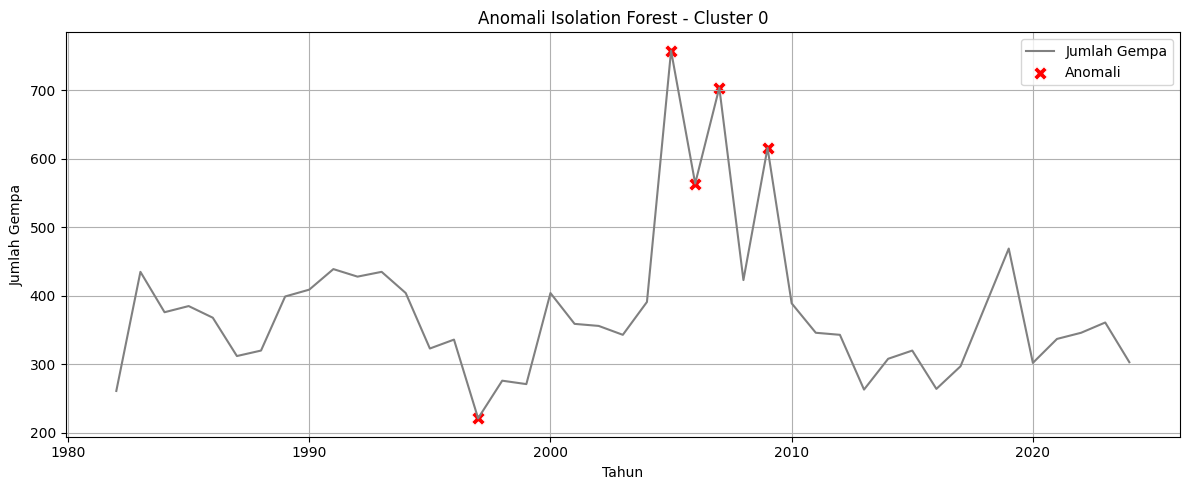


📌 Isolation Forest - Cluster 1
🟥 Tahun anomali: [1982, 1994, 2005, 2006, 2008]


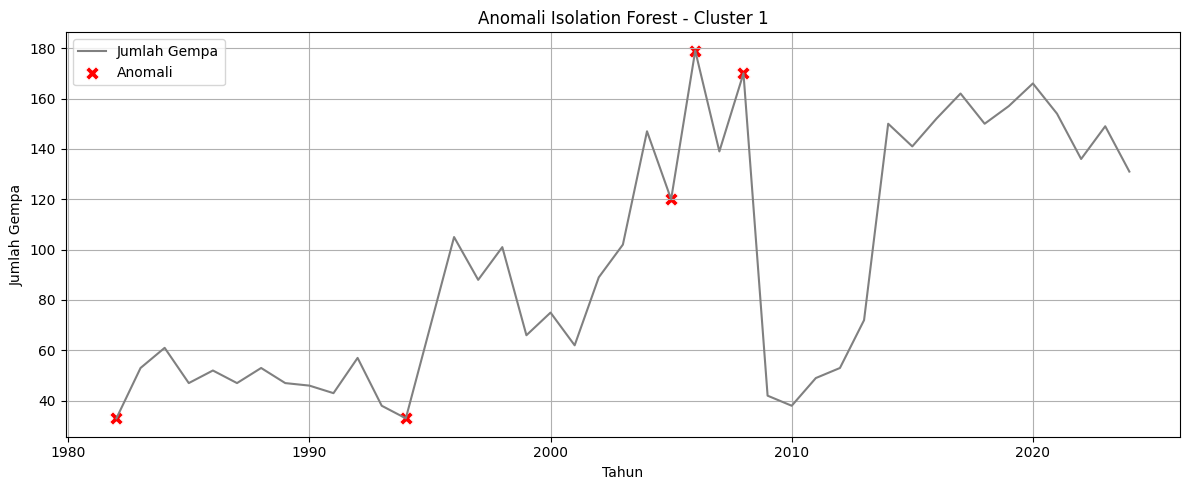


📌 Isolation Forest - Cluster 2
🟥 Tahun anomali: [1982, 2001, 2005, 2006, 2007]


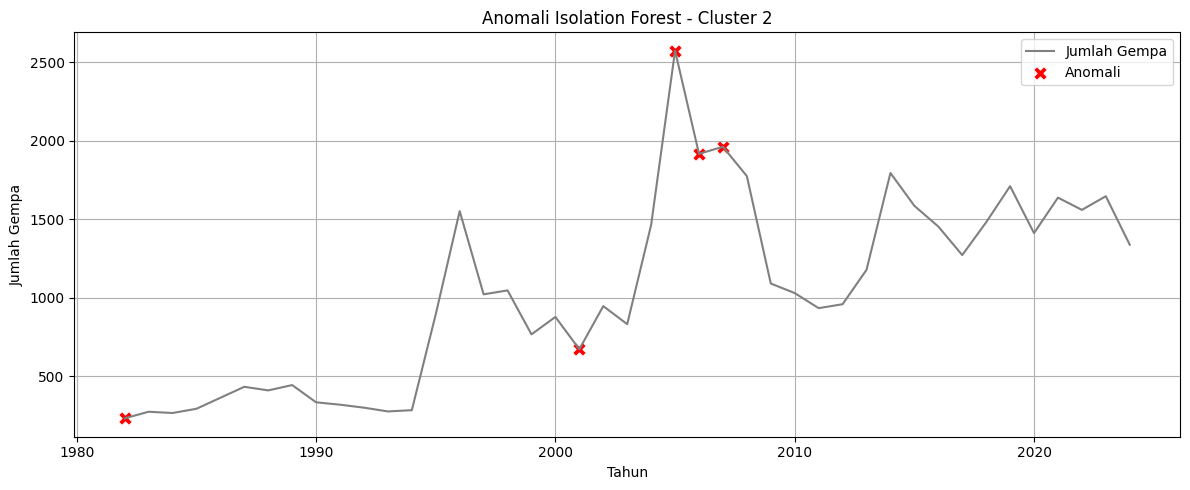

In [114]:
# === 3. Loop Isolation Forest per Cluster ===
for cluster_id in sorted(cluster_counts.columns):
    ts = cluster_counts[cluster_id]
    ts_df = ts.reset_index().rename(columns={cluster_id: 'count'})
    ts_df['cluster'] = cluster_id

    print(f"\n📌 Isolation Forest - Cluster {cluster_id}")
    
    # Model
    iso = IsolationForest(contamination=0.1, random_state=42)
    ts_df['anomaly_iforest'] = iso.fit_predict(ts_df[['count']])
    ts_df['label_iforest'] = ts_df['anomaly_iforest'].map({1: 'Normal', -1: 'Anomali'})

    # Tahun anomali
    tahun_anomali = ts_df[ts_df['label_iforest'] == 'Anomali']['year'].tolist()
    print(f"🟥 Tahun anomali: {sorted(tahun_anomali)}")
    
        # Visualisasi
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=ts_df, x='year', y='count', label='Jumlah Gempa', color='gray')
    sns.scatterplot(data=ts_df[ts_df['label_iforest'] == 'Anomali'],
                    x='year', y='count', color='red', label='Anomali', marker='X', s=100)
    plt.title(f"Anomali Isolation Forest - Cluster {cluster_id}")
    plt.xlabel("Tahun")
    plt.ylabel("Jumlah Gempa")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

One Class-SVM

In [115]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler


📌 One-Class SVM - Cluster 0
🟧 Tahun anomali: [2005, 2006, 2009]


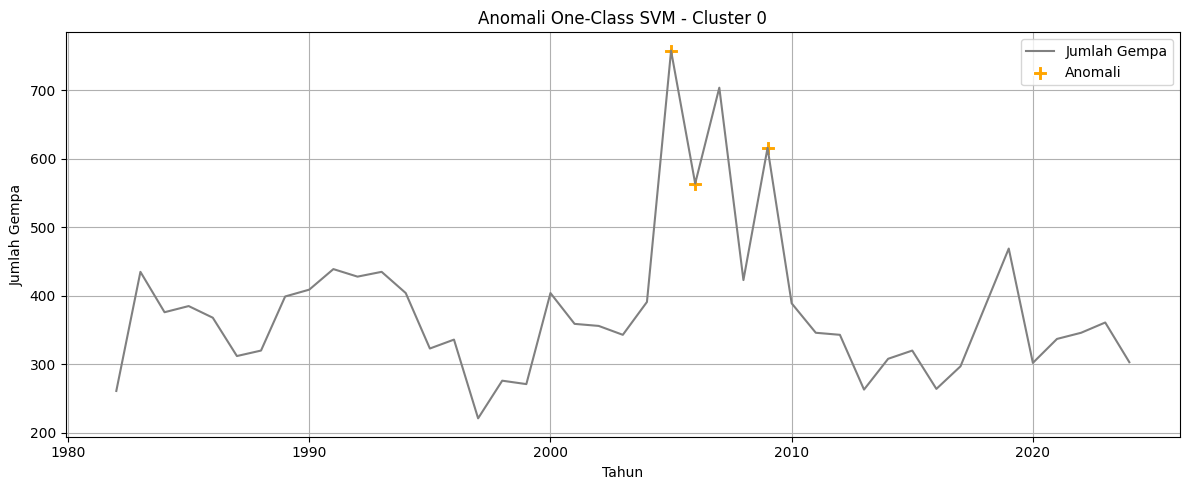


📌 One-Class SVM - Cluster 1
🟧 Tahun anomali: [1982, 1994, 2005, 2006, 2008]


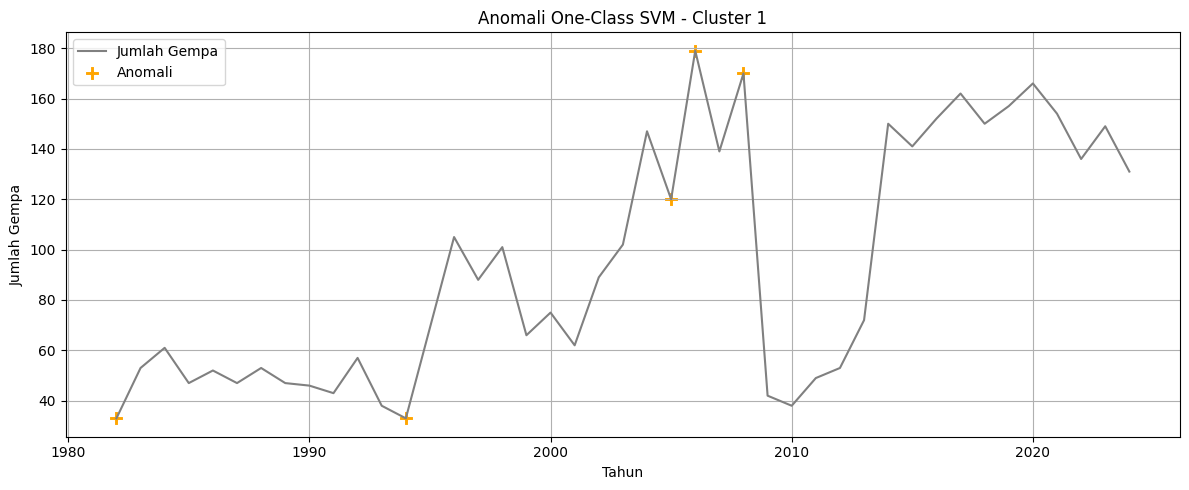


📌 One-Class SVM - Cluster 2
🟧 Tahun anomali: [1982, 1984, 1996, 1997, 1998, 2002, 2004, 2005, 2010, 2012, 2016, 2018, 2022]


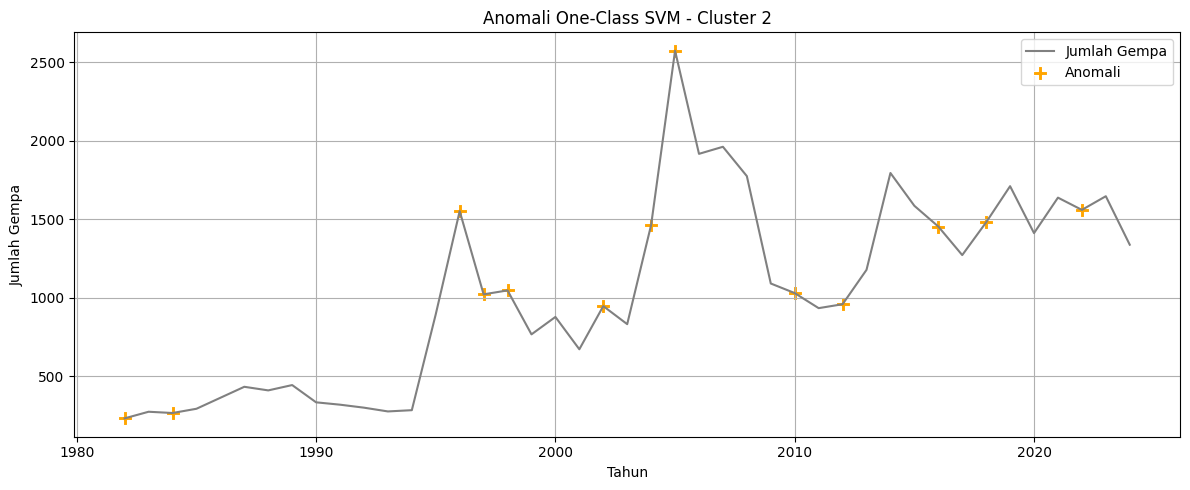

In [116]:
# === 3. Loop SVM per Cluster ===
for cluster_id in sorted(cluster_counts.columns):
    ts = cluster_counts[cluster_id]
    ts_df = ts.reset_index().rename(columns={cluster_id: 'count'})
    ts_df['cluster'] = cluster_id

    print(f"\n📌 One-Class SVM - Cluster {cluster_id}")

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(ts_df[['count']])

    # Model
    svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
    ts_df['anomaly_ocsvm'] = svm.fit_predict(X_scaled)
    ts_df['label_ocsvm'] = ts_df['anomaly_ocsvm'].map({1: 'Normal', -1: 'Anomali'})

    # Tahun anomali
    tahun_anomali = ts_df[ts_df['label_ocsvm'] == 'Anomali']['year'].tolist()
    print(f"🟧 Tahun anomali: {sorted(tahun_anomali)}")

    # Visualisasi
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=ts_df, x='year', y='count', label='Jumlah Gempa', color='gray')
    sns.scatterplot(data=ts_df[ts_df['label_ocsvm'] == 'Anomali'],
                    x='year', y='count', color='orange', label='Anomali', marker='P', s=100)
    plt.title(f"Anomali One-Class SVM - Cluster {cluster_id}")
    plt.xlabel("Tahun")
    plt.ylabel("Jumlah Gempa")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Perbandingan

In [118]:
# Load kembali data hasil clustering jika perlu
df = pd.read_csv("hasil_clustering_gempa.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date', 'cluster'])
df['year'] = df['date'].dt.year
df = df[df['year'] >= 1982]

# Agregasi jumlah gempa per tahun dan cluster
cluster_counts = df.groupby(['year', 'cluster']).size().unstack(fill_value=0)

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# === Perbandingan per cluster ===
for cluster_id in sorted(cluster_counts.columns):
    ts = cluster_counts[cluster_id]
    ts_df = ts.reset_index().rename(columns={cluster_id: 'count'})
    ts_df['cluster'] = cluster_id

    # === Isolation Forest ===
    iso = IsolationForest(contamination=0.1, random_state=42)
    ts_df['label_iforest'] = iso.fit_predict(ts_df[['count']])
    ts_df['label_iforest'] = ts_df['label_iforest'].map({1: 'Normal', -1: 'Anomali'})

    # === One-Class SVM ===
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(ts_df[['count']])
    svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
    ts_df['label_ocsvm'] = svm.fit_predict(X_scaled)
    ts_df['label_ocsvm'] = ts_df['label_ocsvm'].map({1: 'Normal', -1: 'Anomali'})

    # === Ambil tahun anomali ===
    tahun_iforest = set(ts_df[ts_df['label_iforest'] == 'Anomali']['year'])
    tahun_ocsvm = set(ts_df[ts_df['label_ocsvm'] == 'Anomali']['year'])

    # === Cetak Hasil ===
    print(f"\n📊 Perbandingan Deteksi Anomali - Cluster {cluster_id}")
    print(f"✅ Anomali oleh kedua model: {sorted(tahun_iforest & tahun_ocsvm)}")
    print(f"🟥 Hanya oleh Isolation Forest: {sorted(tahun_iforest - tahun_ocsvm)}")
    print(f"🟧 Hanya oleh One-Class SVM: {sorted(tahun_ocsvm - tahun_iforest)}")


📊 Perbandingan Deteksi Anomali - Cluster 0
✅ Anomali oleh kedua model: [2005, 2006, 2009]
🟥 Hanya oleh Isolation Forest: [1997, 2007]
🟧 Hanya oleh One-Class SVM: []

📊 Perbandingan Deteksi Anomali - Cluster 1
✅ Anomali oleh kedua model: [1982, 1994, 2005, 2006, 2008]
🟥 Hanya oleh Isolation Forest: []
🟧 Hanya oleh One-Class SVM: []

📊 Perbandingan Deteksi Anomali - Cluster 2
✅ Anomali oleh kedua model: [1982, 2005]
🟥 Hanya oleh Isolation Forest: [2001, 2006, 2007]
🟧 Hanya oleh One-Class SVM: [1984, 1996, 1997, 1998, 2002, 2004, 2010, 2012, 2016, 2018, 2022]


In [126]:
import pandas as pd

# Data manual dari hasil sebelumnya
data_perbandingan = {
    0: {
        "both": [2005, 2006, 2009],
        "if_only": [1997, 2007],
        "svm_only": []
    },
    1: {
        "both": [1982, 1994, 2005, 2006, 2008],
        "if_only": [],
        "svm_only": []
    },
    2: {
        "both": [1982, 2005],
        "if_only": [2001, 2006, 2007],
        "svm_only": [1984, 1996, 1997, 1998, 2002, 2004, 2010, 2012, 2016, 2018, 2022]
    }
}

# Buat DataFrame dari struktur data
records = []
for cluster_id, hasil in data_perbandingan.items():
    for year in hasil['both']:
        records.append((cluster_id, year, 'Kedua Model'))
    for year in hasil['if_only']:
        records.append((cluster_id, year, 'Hanya IF'))
    for year in hasil['svm_only']:
        records.append((cluster_id, year, 'Hanya SVM'))

df_anomali = pd.DataFrame(records, columns=['Cluster', 'Year', 'Kategori'])


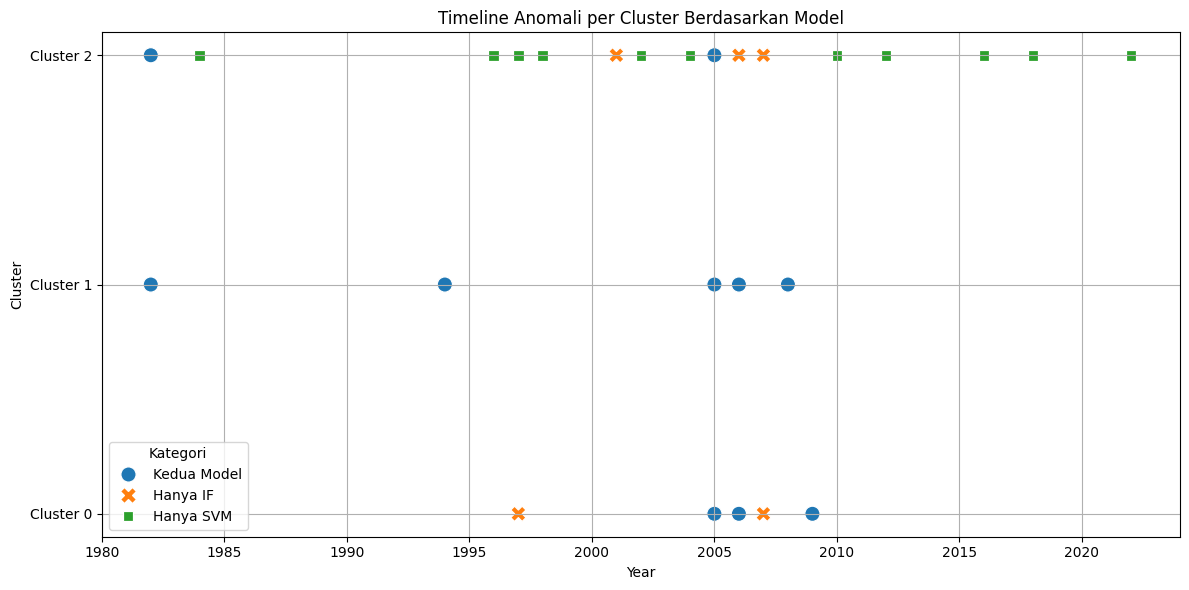

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_anomali, x='Year', y='Cluster', hue='Kategori', style='Kategori', s=120)
plt.yticks([0, 1, 2], ['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.title("Timeline Anomali per Cluster Berdasarkan Model")
plt.grid(True)
plt.tight_layout()
plt.show()


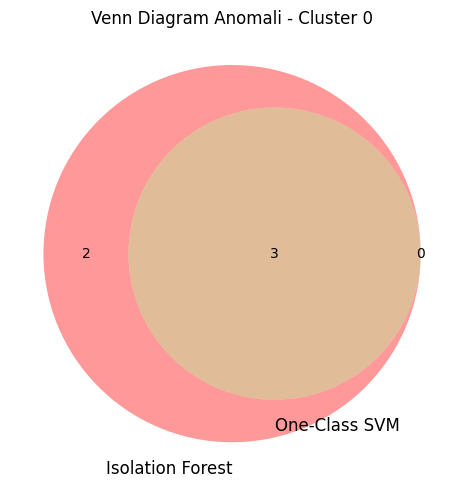

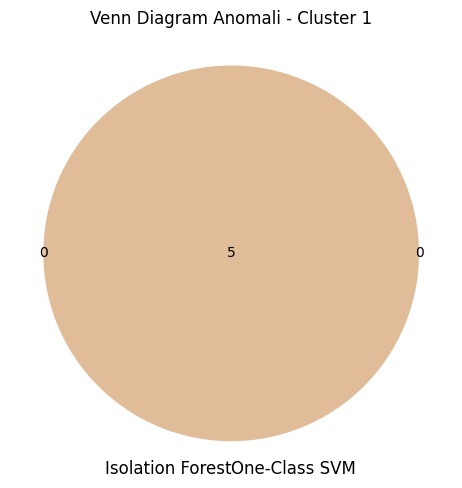

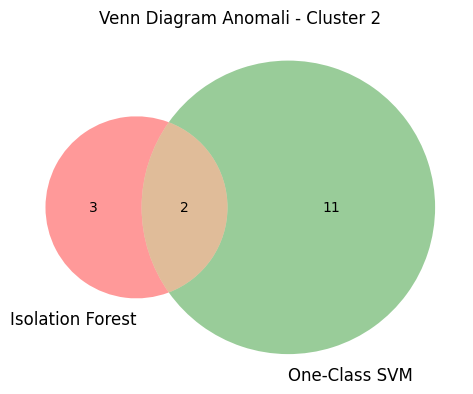

In [128]:
from matplotlib_venn import venn2

data_perbandingan = {
    0: {"both": [2005, 2006, 2009], "if_only": [1997, 2007], "svm_only": []},
    1: {"both": [1982, 1994, 2005, 2006, 2008], "if_only": [], "svm_only": []},
    2: {"both": [1982, 2005], "if_only": [2001, 2006, 2007], "svm_only": [1984, 1996, 1997, 1998, 2002, 2004, 2010, 2012, 2016, 2018, 2022]},
}

for cluster_id, hasil in data_perbandingan.items():
    set_if = set(hasil['both'] + hasil['if_only'])
    set_svm = set(hasil['both'] + hasil['svm_only'])

    plt.figure(figsize=(5,5))
    venn2([set_if, set_svm], set_labels=('Isolation Forest', 'One-Class SVM'))
    plt.title(f"Venn Diagram Anomali - Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()
